# Adverse Impact Mitigation

The purpose of this notebook is to introduce the mitigator classes for Multi-Penalty Optimized models and Iterative Predictor Removal and to plot their validity-diversity tradeoff curves.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from scipy.stats import pearsonr
import seaborn as sns

from ai_mitigation import utils
from ai_mitigation.predictor_removal_mitigation import (
    PredictorRemovalMitigator,
    PredictorRemovalMitigatorCV,
    PredictorRemovalMitigatorTrainTest,
)
from ai_mitigation.mpo_mitigation import (
    MultiPenaltyMitigator,
    MultiPenaltyMitigatorCV,
    MultiPenaltyMitigatorTrainTest,
)
from ai_mitigation.models import MPOClassifier, MPORegressor
from example_data import gen_example_dataset

sns.set()
%matplotlib inline

# Simulated Dataset

In order to demonstrate the basic functionality of the iterative predictor removal and multi-penalty optimization techniques, I will simulate a simple dataset.

This dataset has 8000 examples with both criterion and demographics (Gender=Male/Female). Both techniques support using partially labeled examples (i.e. examples with demographics and without criterion or examples without demographics and with criterion), but I won't demonstrate that here. For simplicity, I will only be mitigating with respect to gender, although both techniques support mitigating on multiple demographic categories.

The simulated dataset contains 11 predictors (features) `X` with criterion (target) `y`. Each predictor is positively correlated to the criterion. The criterion contains a group difference that favors Males. The predictors also contain group differences, but the magnitude and direction of the differences vary from predictor to predictor. Most predictors have group differences that favor Males.  Each "base predictor" has the same "base correlation" to the zero-group differences criterion, but since we added pro-male group differences to the criterion, the more pro-male predictors are slightly more correlated to the criterion.

In [2]:
data = gen_example_dataset()

X = data["X"]
y = data["y"]
demo_df = data["demo"]

X_test = data["X_test"]
y_test = data["y_test"]
demo_df_test = data["demo_test"]

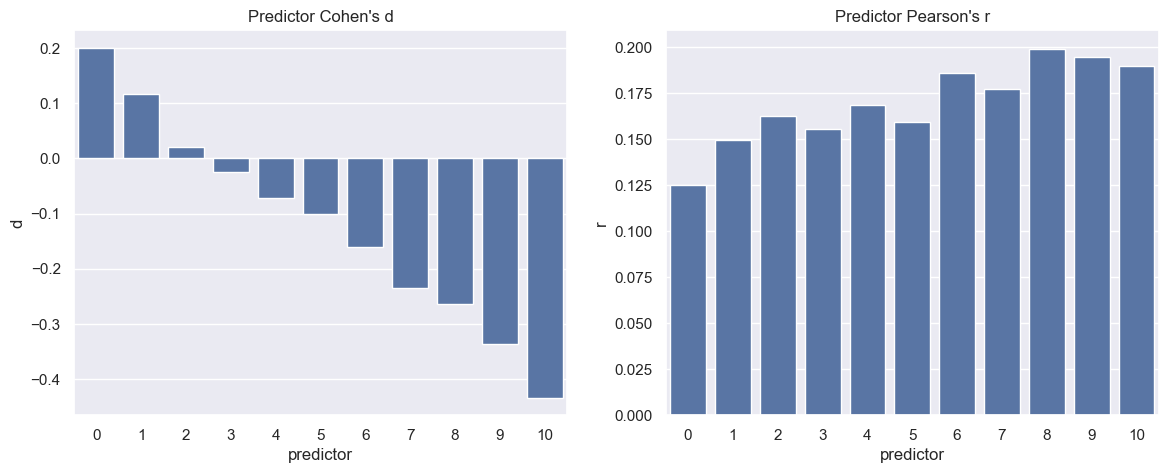

In [3]:
n_predictors = X.shape[1]
predictors = list(range(n_predictors))
predictor_info = pd.DataFrame(data={"predictor": predictors})

for i in range(n_predictors):
    predictor = X[:, i]
    d_info = utils.calc_cohens_d_pairwise(predictor, demo_df.demo_Gender)
    d = d_info.d[("Female", "Male")]
    predictor_info.loc[i, "d"] = d
    predictor_info.loc[i, "r"] = pearsonr(predictor, y)[0]

fig, axes = plt.subplots(1, 2, figsize=[14, 5])
ax = axes[0]
sns.barplot(data=predictor_info, x="predictor", y="d", color="b", ax=ax)
ax.set_title("Predictor Cohen's d")
ax = axes[1]
sns.barplot(data=predictor_info, x="predictor", y="r", color="b", ax=ax)
ax.set_title("Predictor Pearson's r");

Predictor 0 is the most pro-Female predictor, and Predictor 10 is the most pro-Male predictor.

# Unmitigated Model

An unmitigated model has a positive coefficient on every predictor, with slightly larger coefficients on the more pro-Male predictors. Both the criterion (`y`) and the model predictions (`y_pred`) have group differences that favor Males.

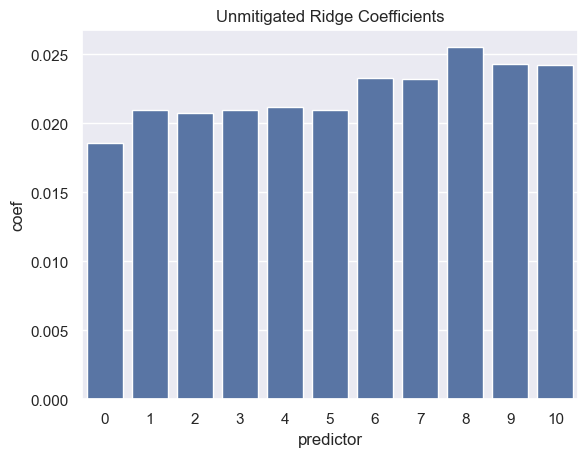

In [4]:
base_model = Ridge()
base_model.fit(X, y)
y_pred = base_model.predict(X)

predictor_info["coef"] = base_model.coef_

sns.barplot(data=predictor_info, x="predictor", y="coef", color="b")
plt.title("Unmitigated Ridge Coefficients");

In [5]:
d_info = utils.calc_cohens_d_pairwise(y, demo_df)
d = d_info.d[("Female", "Male")]
print(f"Cohen's d, y: {d:.3f}")
d_info = utils.calc_cohens_d_pairwise(y_pred, demo_df)
d = d_info.d[("Female", "Male")]
print(f"Cohen's d, y_pred: {d:.3f}")
score, ci = utils.calc_model_score(y, y_pred, "R")
print(f"Model score: R={score:.3f}")

Cohen's d, y: -0.425
Cohen's d, y_pred: -0.388
Model score: R=0.501


# Techniques to reduce group differences

We now demonstrate how iterative predictor removal and multi-penalty optimization work. For multi-penalty optimization, we log sample between 0 and 100. For predictor removal, since we only have 11 predictors, we only remove one predictor per step. 

In [6]:
# multi-penalty optimization parameters
betas = [0, 1, 3, 10, 30, 100]
# iterative predictor removal parameters
predictors_per_step = 1

## Iterative Predictor Removal

In [7]:
pr_mitigator = PredictorRemovalMitigator(
    base_model=base_model,
    predictors_per_step=predictors_per_step,
    verbose=3,
    cross_validate=False,
)

In [8]:
pr_mitigator.run(X, y, demo_df)

  0%|          | 0/11 [00:00<?, ?it/s]

mitigating Female-Male (Max Cohens D=-0.388, R=0.5006)
removing predictors [10]
mitigating Female-Male (Max Cohens D=-0.286, R=0.4786)
removing predictors [9]
mitigating Female-Male (Max Cohens D=-0.198, R=0.4531)
removing predictors [8]
mitigating Female-Male (Max Cohens D=-0.117, R=0.4221)
removing predictors [7]
mitigating Female-Male (Max Cohens D=-0.034, R=0.3909)
removing predictors [6]
mitigating Male-Female (Max Cohens D=-0.035, R=0.3570)
Exiting: Early stopping conditions


Iterative predictor removal removes the 4 most pro-Male predictors and then stops before it would reverse the mitigation targets. The auto-stopping criteria decides to not complete the final step. The final model still has the highest weight on the most pro-Male predictor of the remaining predictors since the model is still incentivized to replicate the group differences found in the criterion.

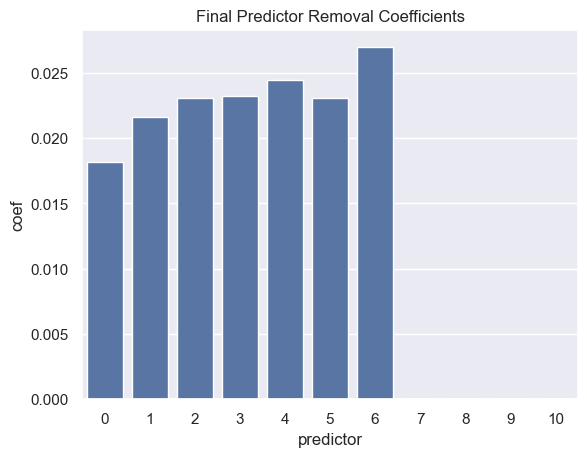

In [9]:
model = pr_mitigator.models[-1]

# Remap coefficients to original model indices
removed_predictors = np.squeeze(pr_mitigator.removed_predictor_names)
predictor_mask = ~np.in1d(predictors, removed_predictors)
adjusted_coef = np.zeros(n_predictors)
adjusted_coef[predictor_mask] = model.coef_

predictor_info["coef"] = adjusted_coef
plt.figure()
sns.barplot(data=predictor_info, x="predictor", y="coef", color="b")
plt.title("Final Predictor Removal Coefficients");

The mitigator class contains methods for calculating the tradeoff between validity (Pearson's R) and group differences (Cohen's d).

In [10]:
pr_mitigator.calc_results_with_ci(pairs=[("Female", "Male")])

Female-Male                  
       R          R (CI)           d            d (CI)
0  0.501  [0.484, 0.517]      -0.388  [-0.432, -0.343]
1  0.479  [0.462, 0.495]      -0.286  [-0.331, -0.242]
2  0.453   [0.435, 0.47]      -0.198  [-0.242, -0.154]
3  0.422   [0.404, 0.44]      -0.117  [-0.161, -0.073]
4  0.391  [0.372, 0.409]      -0.034   [-0.078, 0.009]

## Multi-penalty optimization

In [11]:
mpo_mitigator = MultiPenaltyMitigator(
    sklearn_model=base_model,
    verbose=1,
    betas=betas,
)

In [12]:
mpo_mitigator.run(X, y, demo_df)

  0%|          | 0/6 [00:00<?, ?it/s]

As beta increases, the penalized model increases the coefficients on predictors that decrease the Male-Female group differences and decreases the coefficients of predictors that increase the Male-Female group differences.

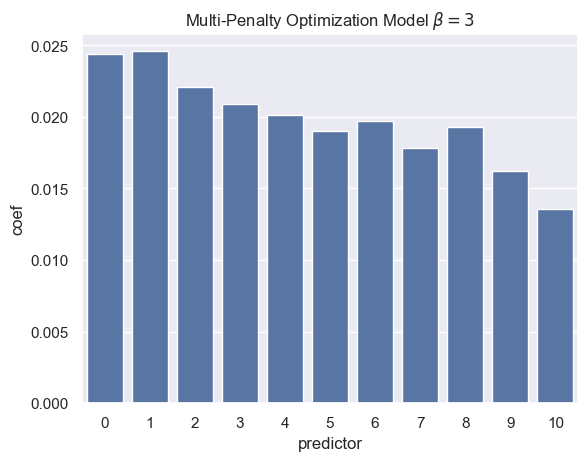

In [13]:
model = mpo_mitigator.models[2]
beta = mpo_mitigator.betas[2]

predictor_info["coef"] = model.coef_
sns.barplot(data=predictor_info, x="predictor", y="coef", color="b")
plt.title(rf"Multi-Penalty Optimization Model $\beta={beta}$");

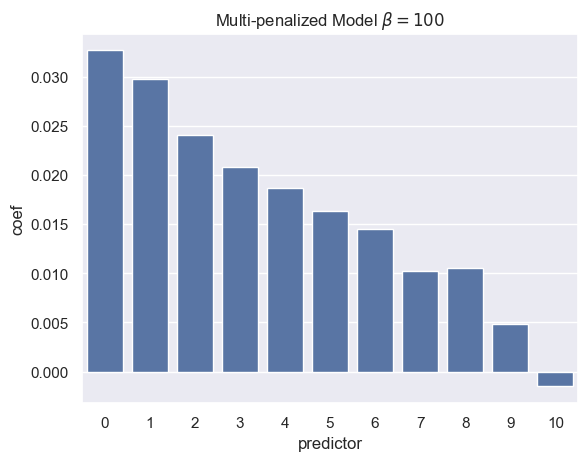

In [14]:
model = mpo_mitigator.models[-1]
beta = mpo_mitigator.betas[-1]

predictor_info["coef"] = model.coef_
sns.barplot(data=predictor_info, x="predictor", y="coef", color="b")
plt.title(rf"Multi-penalized Model $\beta={beta}$");

Both multi-penalty optimization and iterative predictor removal successfully decrease group differences. However, multi-penalty optimization decreases group differences with a smaller hit to predictive validity.

,R,Female-Male,Method
0,0.500568,-0.387639,Multi-penalty Optimization
1,0.498569,-0.335454,Multi-penalty Optimization
3,0.489442,-0.261137,Multi-penalty Optimization
10,0.461826,-0.143297,Multi-penalty Optimization
30,0.434160,-0.061505,Multi-penalty Optimization
100,0.417799,-0.020410,Multi-penalty Optimization
0,0.500568,-0.387618,Predictor Removal
1,0.478575,-0.286480,Predictor Removal
2,0.453082,-0.198218,Predictor Removal
3,0.422062,-0.117295,Predictor Removal


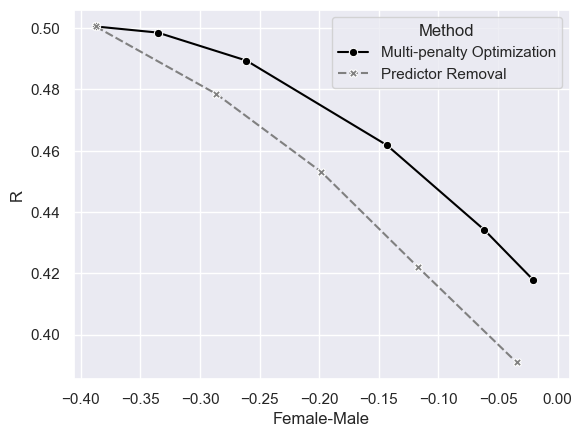

In [15]:
df_results_mpo = mpo_mitigator.calc_results(pairs=[("Female", "Male")])
df_results_pr = pr_mitigator.calc_results(pairs=[("Female", "Male")])

df_results_pr["Method"] = "Predictor Removal"
df_results_mpo["Method"] = "Multi-penalty Optimization"
df_results = pd.concat([df_results_mpo, df_results_pr])

display(df_results)

fig, ax = plt.subplots()
palette = [(0, 0, 0), (0.5, 0.5, 0.5)]
sns.lineplot(
    data=df_results.reset_index(),
    x="Female-Male",
    y="R",
    hue="Method",
    ax=ax,
    marker="o",
    sort=False,
    markers=True,
    style="Method",
    palette=palette,
)
ax.set_xlim(None, 0.01);

# Run with Cross Validation or a Test Set

All the results above have been in-sample results. In this dataset (with 8000 examples and 11 predictors), there isn't too much risk of overfitting, but it is still best practice to do validate these results inside cross validation or a train test split.

Note that for cross validation of the iterative predictor removal, both the model fit _and_ determining which predictors to remove are done using only the training set. Therefore, for cross validation, not every predictor removal removes the exact same predictors.

There are methods for doing both (See `PredictorRemovalMitigatorCV`, `PredictorRemovalMitigatorTrainTest`, `MultiPenaltyMitigatorCV`, `MultiPenaltyMitigatorTrainTest`), but I'll just show results using a train/test split.

In [16]:
pr_mitigator = PredictorRemovalMitigatorTrainTest(
    base_model=base_model,
    predictors_per_step=predictors_per_step,
    verbose=3,
)

# Use this for cross-validated mitigation
# pr_mitigator = PredictorRemovalMitigatorCV(
#     base_model=base_model,
#     predictors_per_step=predictors_per_step,
#     verbose=3,
#     n_splits=5
# )

In [17]:
pr_mitigator.run(X, y, demo_df, X_test, y_test, demo_df_test)

# For cross-validated mitigation
# pr_mitigator.run(X, y, demo_df)

  0%|          | 0/11 [00:00<?, ?it/s]

mitigating Female-Male (Max Cohens D=-0.385, R=0.4961)
removing predictors [10]
mitigating Female-Male (Max Cohens D=-0.283, R=0.4740)
removing predictors [9]
mitigating Female-Male (Max Cohens D=-0.196, R=0.4489)
removing predictors [8]
mitigating Female-Male (Max Cohens D=-0.115, R=0.4177)
removing predictors [7]
mitigating Female-Male (Max Cohens D=-0.032, R=0.3866)
removing predictors [6]
mitigating Male-Female (Max Cohens D=-0.037, R=0.3542)
Exiting: Early stopping conditions


In [18]:
mpo_mitigator = MultiPenaltyMitigatorTrainTest(
    sklearn_model=base_model,
    verbose=1,
    betas=betas,
)

# Use this for cross-validated mitigation
# mpo_mitigator = MultiPenaltyMitigatorCV(
#     sklearn_model=base_model,
#     verbose=1,
#     betas=betas,
# )

In [19]:
mpo_mitigator.run(X, y, demo_df, X_test, y_test, demo_df_test)

# for cross-validated mitigation
# mpo_mitigator.run(X, y, demo_df)

  0%|          | 0/6 [00:00<?, ?it/s]

Both methods are able to decrease group differences out-of-sample. However, like before, the multi-penalty optimization technique does so with less loss of predictive power.

,R,Female-Male,Method
0.0,0.508407,-0.336271,Multi-penalty Optimization
1.0,0.504482,-0.283562,Multi-penalty Optimization
3.0,0.492902,-0.209458,Multi-penalty Optimization
10.0,0.462113,-0.093632,Multi-penalty Optimization
30.0,0.432730,-0.014080,Multi-penalty Optimization
100.0,0.415635,0.025707,Multi-penalty Optimization
0,0.508407,-0.336249,Predictor Removal
1,0.478574,-0.233546,Predictor Removal
2,0.449300,-0.138863,Predictor Removal
3,0.424115,-0.055198,Predictor Removal


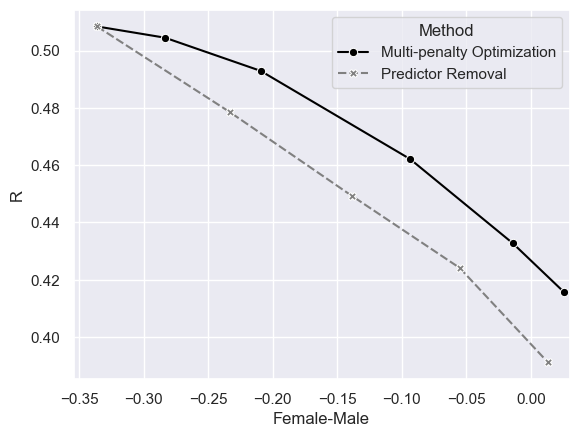

In [20]:
df_results_pr = pr_mitigator.calc_results(pairs=[("Female", "Male")])
df_results_mpo = mpo_mitigator.calc_results(pairs=[("Female", "Male")])

df_results_pr["Method"] = "Predictor Removal"
df_results_mpo["Method"] = "Multi-penalty Optimization"
df_results = pd.concat([df_results_mpo, df_results_pr])

display(df_results)

fig, ax = plt.subplots()
palette = [(0, 0, 0), (0.5, 0.5, 0.5)]
sns.lineplot(
    data=df_results,
    x="Female-Male",
    y="R",
    hue="Method",
    ax=ax,
    marker="o",
    markers=True,
    style="Method",
    palette=palette,
)
ax.set_xlim(None, 0.03);